# Validación Cruzada

Para poder evaluar el rendimiento de un conjunto de datos disminuyendo el sesgo de selección del conjunto de datos de entrenamiento, podemos realizar una serie de particiones del conjunto de datos para así obtener un rendimiento promedio de nuestro método al utilizar distintos conjuntos de entrenamiento y prueba. Esto también nos permite aplicar pruebas estadísticas a nuestras métricas y así poder seleccionar el mejor modelo con mayor certeza.

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
import sklearn.model_selection # Validación cruzada
import sklearn.linear_model
import sklearn.tree
import sklearn.neural_network # Perceptrón multicapa
import sklearn.svm
import sklearn.dummy
import scipy.stats # Prueba estadística
import matplotlib.pyplot as plt

In [2]:
np.random.seed(11) # Establecemos la semilla para el generador de números aleatorios

Importamos un conjunto de datos que contiene datos extraidos de una encuesta en donde se busca inferir el género de la persona en función de un grupo de características.

In [3]:
gender = pd.read_csv("data/gender.csv")

Verificamos que las características son del tipo discretas.

In [4]:
gender.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


Exploramos cómo se distribuyen las características.

In [5]:
gender.describe()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
count,66,66,66,66,66
unique,3,7,6,4,2
top,Cool,Rock,Doesn't drink,Coca Cola/Pepsi,M
freq,37,19,14,32,33


## Preprocesamiento

In [6]:
features = gender.iloc[:,:-1] # Seleccionamos sólo las características del conjunto de datos
label = gender["Gender"] # Seleccionamos la etiqueta del conjunto de datos

Para poder entrenar nuestros modelos debemos transformar nuestras características a una representación vectorial. Para esto utilizamos el método One-Hot Encoding, el cual transforma cada característica en un vector de largo del número de categorías, este vector tiene un 1 en la posición de la categoría asociada a ese ejemplo.

In [7]:
enc = sklearn.preprocessing.OneHotEncoder() # Instanciamos nuestro One-Hot Encoder
features_transformed = pd.DataFrame(
    enc.fit_transform(features).todense(), # Entrenamos nuestro transformador y transformamos las características
    columns = enc.get_feature_names()
)
features_transformed

,x0_Cool,x0_Neutral,x0_Warm,x1_Electronic,x1_Folk/Traditional,x1_Hip hop,x1_Jazz/Blues,x1_Pop,x1_R&B and soul,x1_Rock,x2_Beer,x2_Doesn't drink,x2_Other,x2_Vodka,x2_Whiskey,x2_Wine,x3_7UP/Sprite,x3_Coca Cola/Pepsi,x3_Fanta,x3_Other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
62,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
63,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
64,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
features.iloc[0,:]

Favorite Color                Cool
Favorite Music Genre          Rock
Favorite Beverage            Vodka
Favorite Soft Drink     7UP/Sprite
Name: 0, dtype: object

Pasamos de un espacio de 4 características a uno de 20 características.

In [9]:
features_transformed.iloc[0,:]

x0_Cool                1.0
x0_Neutral             0.0
x0_Warm                0.0
x1_Electronic          0.0
x1_Folk/Traditional    0.0
x1_Hip hop             0.0
x1_Jazz/Blues          0.0
x1_Pop                 0.0
x1_R&B and soul        0.0
x1_Rock                1.0
x2_Beer                0.0
x2_Doesn't drink       0.0
x2_Other               0.0
x2_Vodka               1.0
x2_Whiskey             0.0
x2_Wine                0.0
x3_7UP/Sprite          1.0
x3_Coca Cola/Pepsi     0.0
x3_Fanta               0.0
x3_Other               0.0
Name: 0, dtype: float64

## Modelamiento

In [10]:
def cross_val_score(**kwargs):
    """
    Recibe los argumentos para pasárselos a la función sklearn.model_selection.cross_validate
    Retorna una lista con los valores de AUCROC de cada una de las divisiones.
    """
    cv = sklearn.model_selection.cross_validate( # Esta función entrena un modelo para distintos subconjuntos generados al azar.
        scoring = 'roc_auc', # Usamos la medida de AUCROC para medir el rendimiento de los modelos
        cv = sklearn.model_selection.StratifiedKFold( # La división se realiza de manera estratificada
            n_splits = 10, # Creamos 10 subconjuntos
            shuffle = True, # Desordenamos los datos antes de dividirlos
        ),
        n_jobs = None, # Usamos sólo 1 worker para el entrenmiento
        **kwargs # Pasamos los argumentos recibidos por la función
    )
    return cv["test_score"]

Guardamos los valores de rendimiento para un conjunto de múltiples algoritmos de clasificación.

In [11]:
lr_scores = cross_val_score(
    estimator = sklearn.linear_model.LogisticRegression(),
    X = features_transformed,
    y = label
)
lr_scores

array([0.66666667, 0.75      , 0.66666667, 0.5       , 1.        ,
       0.33333333, 0.77777778, 0.33333333, 0.44444444, 0.77777778])

In [12]:
tree_scores = cross_val_score(
    estimator = sklearn.tree.DecisionTreeClassifier(),
    X = features_transformed,
    y = label
)
tree_scores

array([0.25      , 0.75      , 0.41666667, 0.54166667, 0.875     ,
       0.79166667, 0.66666667, 0.83333333, 0.77777778, 0.55555556])

In [13]:
mlp_scores = cross_val_score(
    estimator = sklearn.neural_network.MLPClassifier(max_iter=1000),
    X = features_transformed,
    y = label
)
mlp_scores

array([0.5       , 0.08333333, 0.83333333, 0.5       , 0.33333333,
       1.        , 0.55555556, 0.55555556, 0.66666667, 0.88888889])

In [14]:
svm_scores = cross_val_score(
    estimator = sklearn.svm.SVC(),
    X = features_transformed,
    y = label
)
svm_scores

array([1.        , 0.66666667, 0.75      , 0.33333333, 0.25      ,
       0.58333333, 1.        , 0.77777778, 0.66666667, 0.61111111])

In [15]:
dummy_scores = cross_val_score(
    estimator = sklearn.dummy.DummyClassifier(strategy="stratified"),
    X = features_transformed,
    y = label
)
dummy_scores

array([0.875     , 0.70833333, 0.41666667, 0.70833333, 0.58333333,
       0.45833333, 0.33333333, 0.33333333, 0.5       , 0.33333333])

## Conclusión

In [16]:
scores = [ # Guardamos todos los resultados en una lista
    lr_scores,
    tree_scores,
    mlp_scores,
    svm_scores,
    dummy_scores
]
names = [
    "Logistic Regression",
    "Decision Tree",
    "Multilayer Perceptron",
    "Support Vector Machine",
    "Dummy Classifier"
]

Con esta visualización podemos ver la distribución de resultados para cada uno de los algoritmos seleccionados.

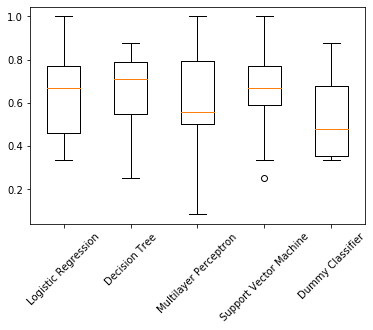

In [17]:
plt.boxplot(
    scores,
    labels = names
)
plt.xticks(rotation=45)
plt.show()

Extraemos el resultado promedio de cada uno de los algoritmos. Al parecer, según una estimación puntual, SVM es el algoritmo que mejor se comporta.

In [18]:
dict(
    zip(
        names,
        map(
            np.mean,
            scores
        )
    )
)

{'Logistic Regression': 0.625,
 'Decision Tree': 0.6458333333333333,
 'Multilayer Perceptron': 0.5916666666666667,
 'Support Vector Machine': 0.663888888888889,
 'Dummy Classifier': 0.525}

Para verificar si la diferencia entre las medias de los resultados es estadísticamente significativa utilizamos una prueba de ANOVA.
No existen diferencias estadísticamente significativas entre cada uno de los algoritmos.

In [19]:
scipy.stats.f_oneway(*scores)

F_onewayResult(statistic=0.5829889548425878, pvalue=0.6765294405020901)